# Emittance minimization using Xopt with BAXGenerator running algorithm ScipyMinimizeEmittance
In this notebook we demonstrate the use of Xopt to perform Bayesian Algorithm Execution (BAX) as a means of minimizing the emittance described by a simple optical beam size model. BAX is a generalization of Bayesian Optimization that seeks to acquire observations that provide our model with maximal information about our property of interest. In this example, our property of interest is the minimal emittance and its location in tuning-parameter-space. See https://arxiv.org/pdf/2209.04587.pdf for details.

# Imports

In [1]:
# Ignore all warnings
import warnings
# warnings.filterwarnings("ignore")

import sys
# sys.path.append('C:\\Users\\Dylan\\SLAC') #parent directory containing emitopt module

import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator

from xopt.evaluator import Evaluator

from emitopt.analysis import compute_emit_bmag
from emitopt.sampling import draw_product_kernel_post_paths
from emitopt.algorithms import ScipyMinimizeEmittanceXY

import time
import numpy as np
import random

# Use CUDA if available

In [2]:
# if torch.cuda.is_available():
if False:
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
    use_cuda = True
else:
    torch.set_default_tensor_type('torch.DoubleTensor')
    use_cuda = False

C:\Users\Dylan\AppData\Roaming\Python\Python39\site-packages\torch\__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


# Notebook settings

In [3]:
ndim = 4 #number of input dimensions
noise = False #whether to add noise to the ground-truth beam size function outputs
thick_quad = False
meas_dim = 1 #input dimension for measurement parameter
n_obs_init = 7 #number of random initial observations for GP model
n_samples = 20 #number of posterior samples for BAX
n_iter = 10 #number of optimization steps for Xopt to take (after acquiring random initial data)
rand_seed = 3

#random seeds for reproducibility 
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) #only affects initial random observations through Xopt
random.seed(rand_seed)

# Build test function from single-quadrupole optical beam size model 
Here we define a simple ground-truth beam size function for our optimization problem, where we attempt to find the location in tuning parameter space with minimal emittance. Note that the function "test_func" used to evaluate the ground-truth beam size function takes a dictionary as input and returns a dictionary as the output.

In [4]:
from pyemittance.emittance_calc import EmitCalc
from pyemittance.load_json_configs import load_configs
from pyemittance.simulation import BeamSim

CONFIG = load_configs('LCLS2_OTR0H04')
CONFIG['beamline_info']

q_len = CONFIG['beamline_info']['Lquad']
rmat_x = torch.tensor(CONFIG['beamline_info']['rMatx']).reshape(2,2)
rmat_y = torch.tensor(CONFIG['beamline_info']['rMaty']).reshape(2,2)
print(rmat_x)
print(rmat_y)

tensor([[1.0000, 2.2000],
        [0.0000, 1.0000]])
tensor([[1.0000, 2.2000],
        [0.0000, 1.0000]])


In [5]:
BUNCH_PARAMS0 = {
    'total_charge': 50e-12,
    'norm_emit_x': 1e-6,
    'norm_emit_y': 2e-6,
    'beta_x': 10,
    'alpha_x': -1,
    'beta_y': 11,
    'alpha_y': -2,
    'energy': 80e6,
    'species':'electron'
}
sim = BeamSim(bunch_params=BUNCH_PARAMS0, beamline_info=CONFIG['beamline_info'])


# define variables functions
var_names = ['x' + str(i) for i in range(ndim)]
meas_param = var_names[meas_dim]

scale = 1.e3
def measure_beamsize(input_dict):
    x_tuning = torch.tensor([])
    for key in input_dict.keys():
        if key is not meas_param:
            x_tuning = torch.cat((x_tuning, torch.tensor([input_dict[key]])))
    rms_beamsizes0 = np.array(sim.beam_size_meas(input_dict[meas_param]))
    detuning_scale = 1. + 1*x_tuning.abs().sum().cpu()
    xrms, yrms = detuning_scale * rms_beamsizes0
    return {'xrms_sq': (float(xrms)*scale)**2.,
            'yrms_sq': (float(yrms)*scale)**2.} # mean-square beam sizes in mm squared

from emitopt.utils import get_quad_scale_factor
scale_factor = get_quad_scale_factor(E=.08, q_len=q_len)
# scale_factor = 1.
q = torch.linspace(-3,3,20)
bs = torch.tensor([np.array(sim.beam_size_meas(v))*scale for v in q.numpy()]).T
print(bs)
k = scale_factor*q
ks = torch.stack((k,-k))
rmats = torch.stack((rmat_x, rmat_y))
emit, bmag, sig, is_valid = compute_emit_bmag(ks, bs**2, q_len, rmats, thick=True)
print(emit[0], emit[1])
gt_emit_min = (emit[0]*emit[1]).sqrt()
def ground_truth_geometric_mean_emittance(emit_min, x_tuning):
    detuning_scale = 1. + x_tuning.abs().sum(dim=1)
    emit = emit_min * detuning_scale**2
    return emit

print('Ground truth minimum emit:', gt_emit_min)

tensor([[0.9752, 0.9042, 0.8337, 0.7634, 0.6936, 0.6241, 0.5550, 0.4864, 0.4182,
         0.3506, 0.2836, 0.2176, 0.1536, 0.0946, 0.0575, 0.0809, 0.1362, 0.1979,
         0.2613, 0.3252],
        [0.4155, 0.3205, 0.2269, 0.1385, 0.0781, 0.1120, 0.1969, 0.2917, 0.3896,
         0.4890, 0.5895, 0.6907, 0.7926, 0.8952, 0.9983, 1.1019, 1.2061, 1.3109,
         1.4161, 1.5219]])
tensor(0.0064) tensor(0.0128)
Ground truth minimum emit: tensor(0.0090)


C:\Users\Dylan\AppData\Local\Temp\ipykernel_25284\553575912.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  bs = torch.tensor([np.array(sim.beam_size_meas(v))*scale for v in q.numpy()]).T


# Construct vocs

In [6]:
variables = {var_name: [-5,2] for var_name in var_names}
variables[meas_param] = [-3,3] #overwrite bounds for measurement parameter to capture minimum of single-quadrupole optical model

#construct vocs
vocs = VOCS(
    variables = variables,
    observables = ['xrms_sq', 'yrms_sq'],
)

print('variable_names =', vocs.variable_names)
print('meas_param =', "'" + meas_param + "'")
print('domain =\n', vocs.bounds.T)

variable_names = ['x0', 'x1', 'x2', 'x3']
meas_param = 'x1'
domain =
 [[-5.  2.]
 [-3.  3.]
 [-5.  2.]
 [-5.  2.]]


# Prepare generator options.
In this example, we use a specialty covariance module (Matern x Quadratic kernel) for our beam size model.

In [7]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt.generators.bayesian.bax_generator import BaxGenerator
from emitopt.algorithms import ScipyMinimizeEmittanceXY

# prepare custom covariance module
tuning_dims = list(range(vocs.n_variables))
tuning_dims.remove(meas_dim)
covar_module_x = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )

scaled_covar_module_x = ScaleKernel(covar_module_x)#, outputscale_prior=GammaPrior(2.0, 0.15))
covar_module_y = (MaternKernel(ard_num_dims=len(tuning_dims), 
                              active_dims=tuning_dims, 
                              lengthscale_prior=None) * 
                              PolynomialKernel(power=2, active_dims=[meas_dim])
                 )
scaled_covar_module_y =  ScaleKernel(covar_module_y)#, outputscale_prior=GammaPrior(2.0, 0.15))

# prepare options for Xopt generator
covar_module_dict = {'xrms_sq': scaled_covar_module_x,
                     'yrms_sq': scaled_covar_module_y}

model_constructor = StandardModelConstructor(covar_modules=covar_module_dict, use_low_noise_prior=True)

In [8]:
from xopt.numerical_optimizer import LBFGSOptimizer, GridOptimizer
numerical_optimizer = LBFGSOptimizer(
                                    n_restarts=20,
                                    max_time=2)
# numerical_optimizer = GridOptimizer()

# Construct generator, evaluator, Xopt objects

In [9]:
#Prepare Algorithm
algo_kwargs = {
        'x_key': 'xrms_sq',
        'y_key': 'yrms_sq',
        'scale_factor': scale_factor,
        'q_len': q_len,
        'rmat_x': rmat_x,
        'rmat_y': rmat_y,
        'n_samples': n_samples,
        'meas_dim': meas_dim,
        'n_steps_measurement_param': 20,
        'scipy_options': {'maxiter':25},
        'thick_quad': thick_quad,
        'init': 'smallest',
        'jitter': 0.1,
        'transform_target': True
}
algo = ScipyMinimizeEmittanceXY(**algo_kwargs)

#construct BAX generator
generator = BaxGenerator(vocs=vocs, 
                         gp_constructor=model_constructor, 
                         numerical_optimizer=numerical_optimizer,
                         algorithm=algo, 
                         use_cuda=use_cuda)

#construct evaluator
evaluator = Evaluator(function=measure_beamsize)

#construct Xopt optimizer
optimizer = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

# Optimize

In [10]:
# call X.random_evaluate() to generate random initial points and evaluate on test_func
optimizer.random_evaluate(n_obs_init)

,x0,x1,x2,x3,xrms_sq,yrms_sq,xopt_runtime,xopt_error
0,-1.855585,1.756543,-2.733784,-2.851965,0.502070,87.546422,0.000530,False
1,-2.957035,2.691197,-2.136040,-1.083176,3.554028,103.619296,0.000227,False
2,-0.036333,0.355141,1.832127,0.901926,0.834218,6.055007,0.000218,False
3,-1.575793,2.820743,-1.911979,-1.812543,3.312736,84.822082,0.000231,False
4,-4.250629,0.259001,0.185233,-3.462203,5.449148,30.613954,0.000250,False
5,-4.274052,-0.894864,-0.905708,-0.144545,10.372961,2.694654,0.000331,False
6,1.120903,1.329076,0.015324,0.446295,0.026846,6.251878,0.000340,False


C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-10.
  warnings.warn(
c:\users\dylan\slac\emitopt\emitopt\sampling.py:117: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:1703.)
  Lnn = torch.cholesky(K.to_dense())
C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: Num

(<Figure size 800x960 with 11 Axes>,
 array([[<AxesSubplot: title={'center': 'Posterior Mean [xrms_sq]'}, ylabel='x1'>,
         <AxesSubplot: title={'center': 'Posterior SD [xrms_sq]'}>],
        [<AxesSubplot: title={'center': 'Posterior Mean [yrms_sq]'}, ylabel='x1'>,
         <AxesSubplot: title={'center': 'Posterior SD [yrms_sq]'}>],
        [<AxesSubplot: title={'center': 'Acq. Function'}, xlabel='x0', ylabel='x1'>,
         <AxesSubplot: xlabel='x0'>]], dtype=object))

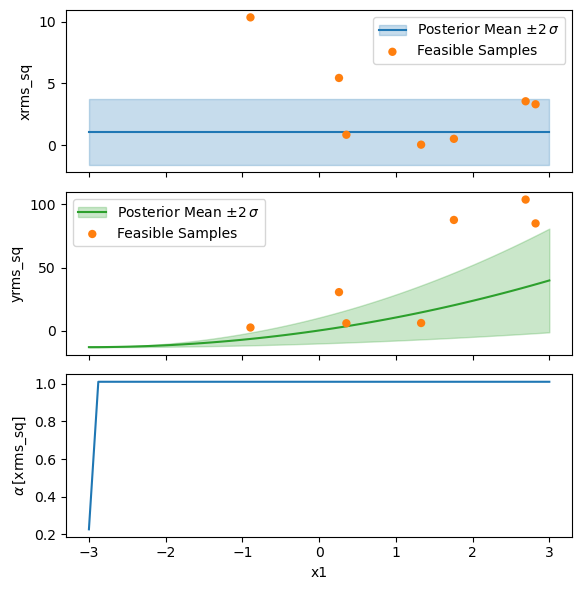

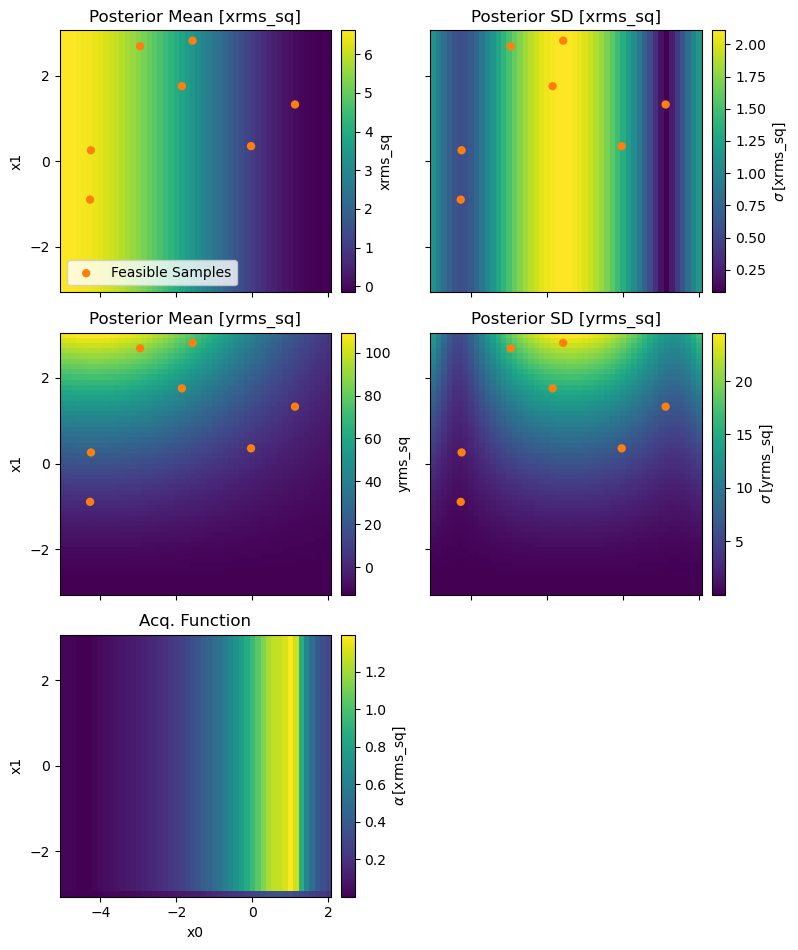

In [11]:
from xopt.generators.bayesian.visualize import visualize_generator_model
optimizer.generator.train_model()
visualize_generator_model(optimizer.generator, variable_names=['x1'], reference_point={'x0':torch.tensor([0.]), 'x2':torch.tensor([0.]), 'x3':torch.tensor([0.])})
visualize_generator_model(optimizer.generator, variable_names=['x0','x1'], reference_point={'x2':torch.tensor([0.]), 'x3':torch.tensor([0.])})

In [12]:
# torch.tensor(optimizer.data[vocs.variable_names].iloc[-2].to_numpy().reshape(1,-1))

In [13]:
results = []

In [14]:
# plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
# plt.xlabel('Predicted Optimal Emittance')
# plt.ylabel('Probability Density')
# plt.show()
# print('sample validity rate:', svr)

for i in range(1, n_iter+1):

    print('Iteration:', i, '/', n_iter)

    start = time.time()

    # call X.step() to generate a random initial point and evaluate on test_func
    optimizer.step()    

    
    #extract GP models
    model = optimizer.generator.train_model()
    bax_model_ids = [optimizer.generator.vocs.output_names.index(name)
                            for name in optimizer.generator.algorithm.observable_names_ordered]
    bax_model = model.subset_output(bax_model_ids)
    beam_size_model_x = bax_model.models[0]
    beam_size_model_y = bax_model.models[1]
    
    #extract and store algorithm results for this iteration
    results += [optimizer.generator.algorithm_results]
#     beam_size_models[i] = beam_size_model
    
    #get mean-predicted optimal tuning config and eval predicted emits at this location in tuning parameter space
    algo = optimizer.generator.algorithm
#     X_tuned, emits_at_target_valid, svr = algo.mean_output(beam_size_model,
#                                                          torch.tensor(vocs.bounds),
#                                                          num_restarts=10)
    
    end = time.time()
    print('This iteration took:', end-start, 'seconds.\n')

#     if i % 5 == 0:
#         plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
#         plt.xlabel('Predicted Optimal Emittance')
#         plt.ylabel('Probability Density')
#         plt.show()
#         print('sample validity rate:', svr)

Iteration: 1 / 10
This iteration took: 5.247707843780518 seconds.

Iteration: 2 / 10
This iteration took: 7.068629026412964 seconds.

Iteration: 3 / 10
This iteration took: 7.042547941207886 seconds.

Iteration: 4 / 10
This iteration took: 4.917639970779419 seconds.

Iteration: 5 / 10
This iteration took: 4.519603967666626 seconds.

Iteration: 6 / 10
This iteration took: 4.439830541610718 seconds.

Iteration: 7 / 10
This iteration took: 4.573309898376465 seconds.

Iteration: 8 / 10
This iteration took: 4.896011829376221 seconds.

Iteration: 9 / 10
This iteration took: 4.905850172042847 seconds.

Iteration: 10 / 10
This iteration took: 4.888128042221069 seconds.



(<Figure size 800x960 with 11 Axes>,
 array([[<AxesSubplot: title={'center': 'Posterior Mean [xrms_sq]'}, ylabel='x1'>,
         <AxesSubplot: title={'center': 'Posterior SD [xrms_sq]'}>],
        [<AxesSubplot: title={'center': 'Posterior Mean [yrms_sq]'}, ylabel='x1'>,
         <AxesSubplot: title={'center': 'Posterior SD [yrms_sq]'}>],
        [<AxesSubplot: title={'center': 'Acq. Function'}, xlabel='x0', ylabel='x1'>,
         <AxesSubplot: xlabel='x0'>]], dtype=object))

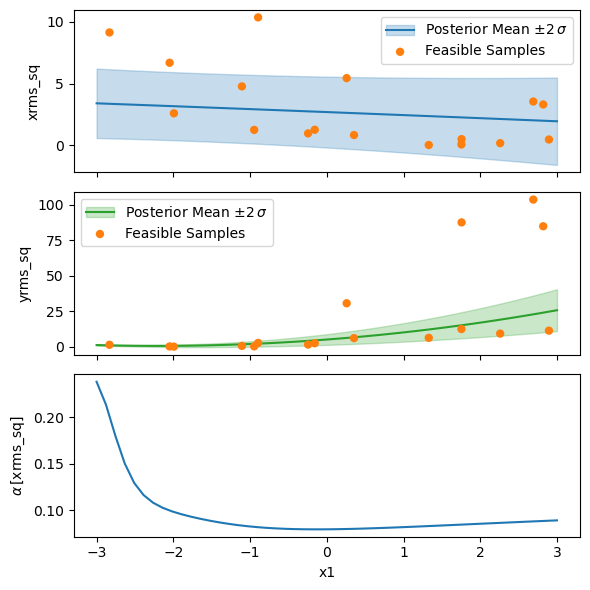

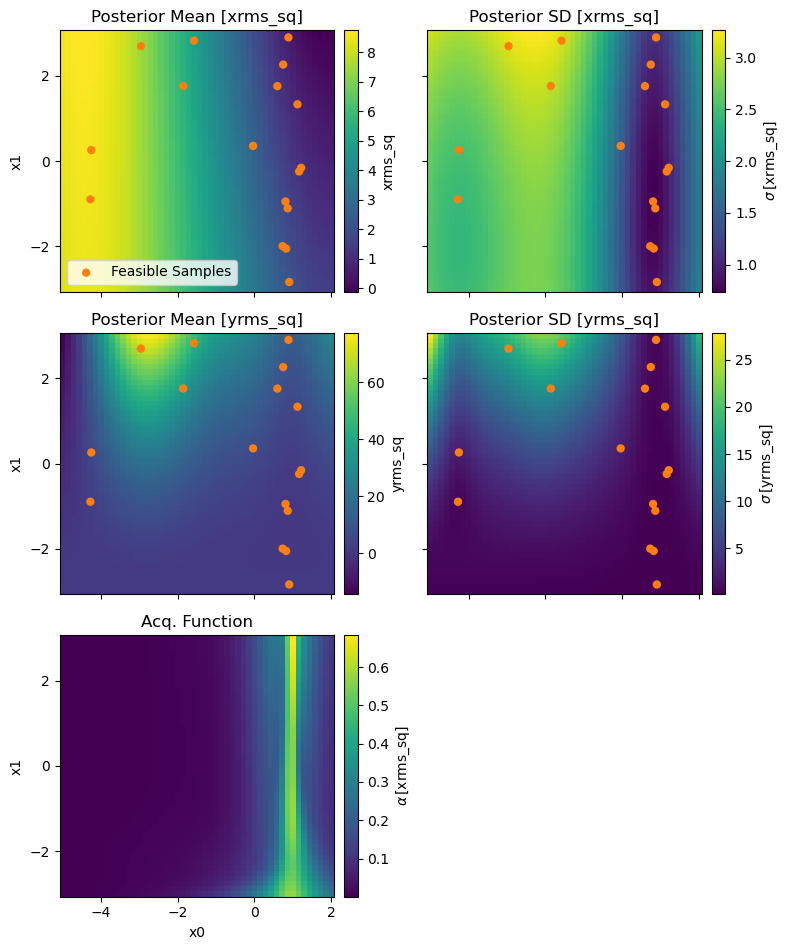

In [15]:
optimizer.generator.train_model()
# visualize_generator_model(optimizer.generator, variable_names=['x1'], reference_point={'x0':torch.tensor([0.]), 'x2':torch.tensor([0.])})
# visualize_generator_model(optimizer.generator, variable_names=['x0','x1'], reference_point={'x2':torch.tensor([0.])})
visualize_generator_model(optimizer.generator, variable_names=['x1'], reference_point={'x0':torch.tensor([0.]), 'x2':torch.tensor([0.]), 'x3':torch.tensor([0.])})
visualize_generator_model(optimizer.generator, variable_names=['x0','x1'], reference_point={'x2':torch.tensor([0.]), 'x3':torch.tensor([0.])})

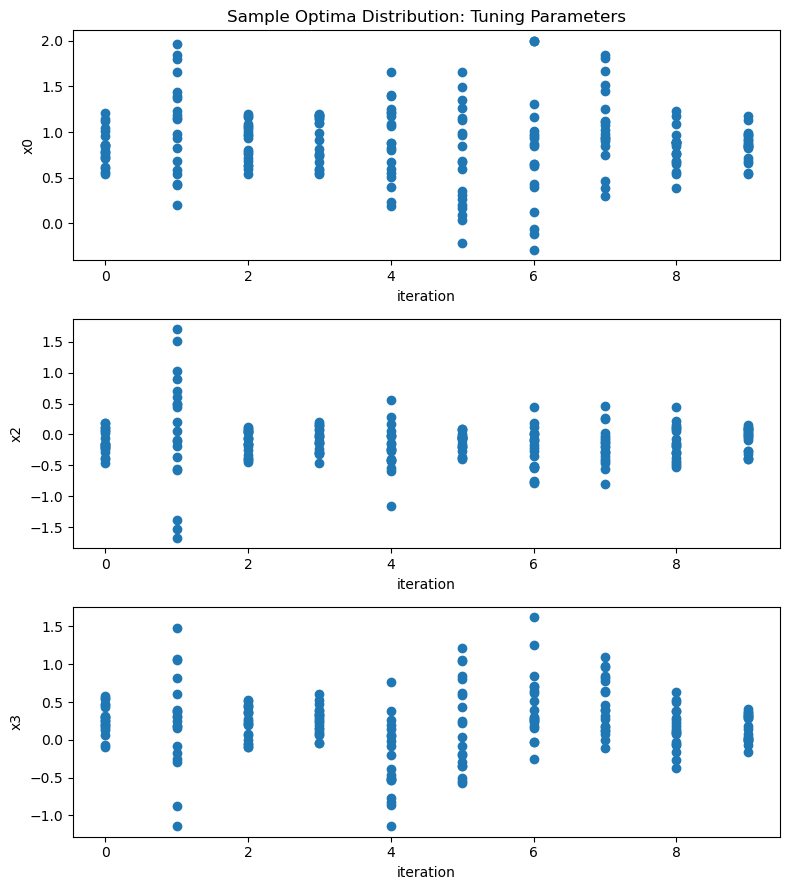

In [16]:
from emitopt.plot_utils import plot_sample_optima_convergence_inputs
fig, axs = plot_sample_optima_convergence_inputs(optimizer.generator, results, show_valid_only=False)
# for ax in axs:
#     ax.axhline(0, ls='--', c='k')

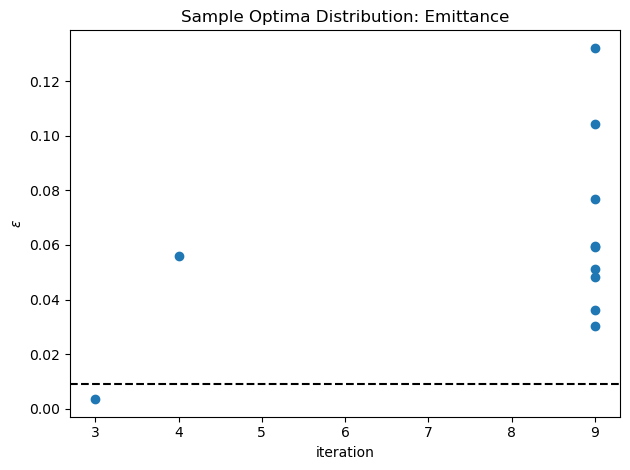

In [17]:
from emitopt.plot_utils import plot_sample_optima_convergence_emits
fig, ax = plot_sample_optima_convergence_emits(results)
ax.axhline(gt_emit_min, ls='--', c='k', label='ground truth')

In [18]:
print(optimizer.generator.algorithm_results['x_tuning_best'])
x_tuning_best = optimizer.generator.algorithm_results['x_tuning_best'].mean(dim=0)
print(x_tuning_best)

tensor([[[ 0.5887,  0.2123,  0.6182]],

        [[ 0.9104, -0.4726,  0.1463]],

        [[ 0.2788, -0.3999, -0.3863]],

        [[ 1.0356, -0.0214, -0.1075]],

        [[ 0.8167, -0.0996, -0.5218]],

        [[ 1.0718,  0.1390, -0.2623]],

        [[ 0.4659, -0.1103,  0.2292]],

        [[ 0.9415,  0.1374,  0.4386]],

        [[ 0.8848, -0.2498, -0.0903]],

        [[ 1.0150, -0.2130,  0.3174]],

        [[ 1.3515, -0.0207, -0.2838]],

        [[ 0.9782, -0.1939, -0.5860]],

        [[ 0.9789, -0.0324,  0.0430]],

        [[ 0.9478,  0.0162, -0.1674]],

        [[ 0.7603, -0.3113, -0.3931]],

        [[ 1.0303, -0.1382, -0.0936]],

        [[ 0.9024, -0.0212, -0.1716]],

        [[ 1.0534,  0.0948, -0.1569]],

        [[ 0.8436,  0.1359, -0.1863]],

        [[ 1.0852, -0.3681, -0.2736]]])
tensor([[ 0.8970, -0.0959, -0.0944]])


(<Figure size 900x300 with 3 Axes>,
 array([<AxesSubplot: xlabel='tuning param 0', ylabel='$\\epsilon}$'>,
        <AxesSubplot: xlabel='tuning param 1'>,
        <AxesSubplot: xlabel='tuning param 2'>], dtype=object))

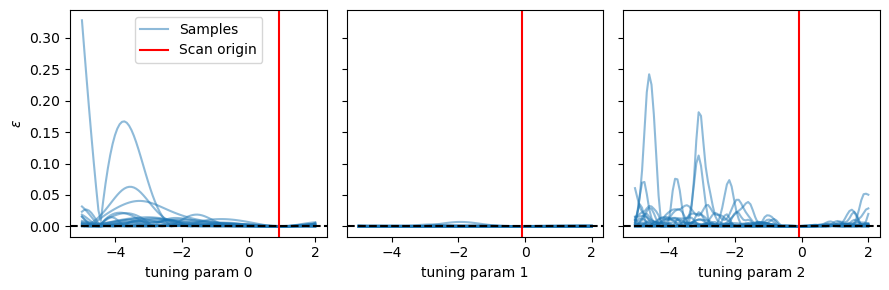

In [19]:
from emitopt.plot_utils import plot_pathwise_emittance_vs_tuning
plot_pathwise_emittance_vs_tuning(optimizer, x_tuning_best, transform_target=True)

# Sample geometric mean of emittance x&y

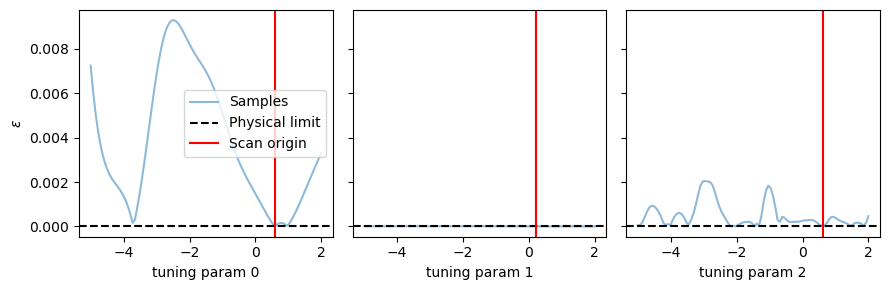

In [20]:
from emitopt.plot_utils import plot_pathwise_emittance_vs_tuning
sid = 0
X_tuned = optimizer.generator.algorithm_results['x_tuning_best'][sid:sid+1, 0, :]

fig, axs = plot_pathwise_emittance_vs_tuning(optimizer, x_origin=X_tuned, sample_ids=[sid], transform_target=True)#, ground_truth_emittance_fn=ground_truth_geometric_mean_emittance)
# X_tuning_scan = X_tuned.repeat(100,1)
# ls = torch.linspace(*optimizer.vocs.bounds.T[0],100)
# ls = torch.linspace(-1,1,100)
# X_tuning_scan[:,i] = ls
# gt_emit_xy = ground_truth_geometric_mean_emittance(emit_min=gt_emit_min, x_tuning=X_tuning_scan)

# for ax in axs:
#     ax.plot(ls, gt_emit_xy**4, c='k', label='ground truth')

C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


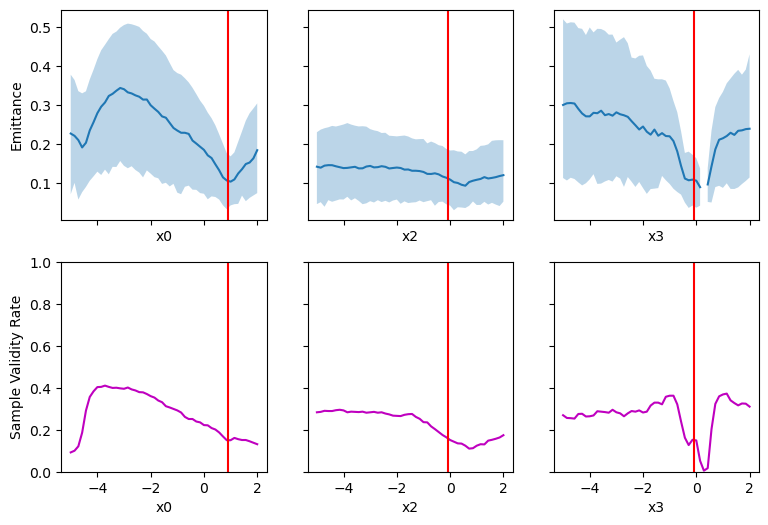

In [38]:
from emitopt.plot_utils import plot_virtual_emittance
from emitopt.utils import x_tuning_to_dict
reference_point = x_tuning_to_dict(optimizer.generator, x_tuning_best)
fig, axs = plot_virtual_emittance(optimizer, reference_point, dim='xy', n_samples=1000)

In [22]:
from emitopt.utils import x_tuning_to_tensor
x_tuning = x_tuning_to_tensor(optimizer.generator, reference_point)
x_tuning

tensor([[ 0.8970, -0.0959, -0.0944]])

In [23]:
x_tuning_best

tensor([[ 0.8970, -0.0959, -0.0944]])

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'Mean-Square Beam Size GP Model Output'}, xlabel='Measurement Quad Setting (Machine Units)', ylabel='Mean-Square Beam Size (mm)'>)

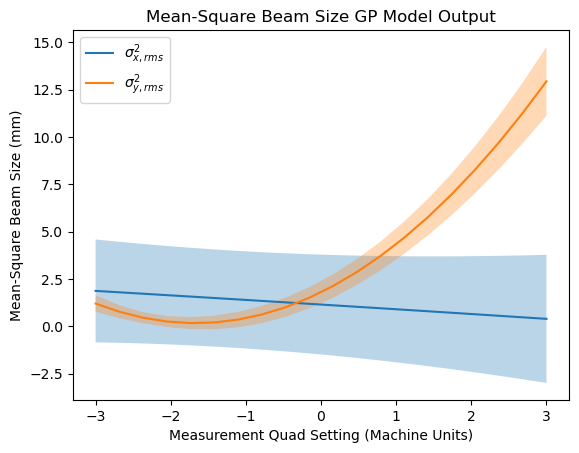

In [24]:
from emitopt.plot_utils import plot_virtual_measurement_scan
plot_virtual_measurement_scan(optimizer, reference_point)

get_acquisition took 1.8050541877746582 seconds.
optimize_acqf took 0.9125332832336426 seconds.


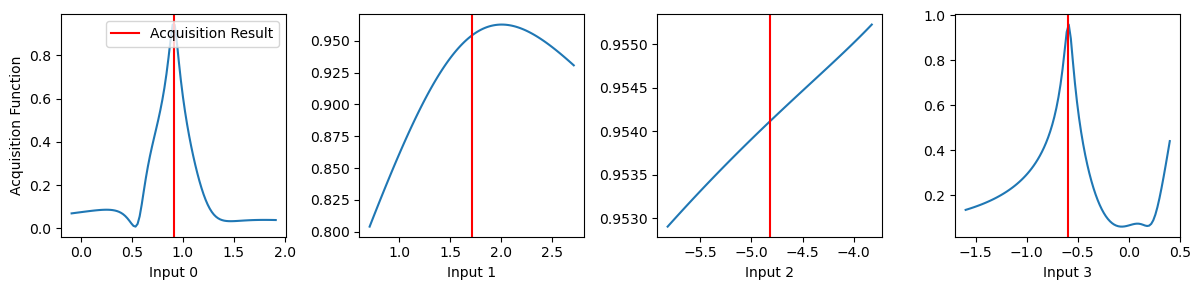

In [25]:
from emitopt.plot_utils import plot_acq_func_opt_results
plot_acq_func_opt_results(optimizer)

In [26]:
n_steps_grid = 5
bounds = torch.tensor(vocs.bounds)
meas_dim = optimizer.generator.algorithm.meas_dim
temp_id = meas_dim + 1
tuning_domain = torch.cat((bounds.T[: meas_dim], bounds.T[temp_id:]))
tuning_domain
linear_grids = []
for lower, upper in tuning_domain:
    linear_grids += [torch.linspace(lower, upper, n_steps_grid)]
x_tuning_mesh = torch.meshgrid(linear_grids)
mesh_shape = x_tuning_mesh[0].shape
x_tuning_mesh = [mesh.reshape(-1,1) for mesh in x_tuning_mesh]
x_tuning_mesh_serialized = torch.cat(x_tuning_mesh, dim=1)
emit, is_valid = optimizer.generator.algorithm.evaluate_posterior_emittance_samples(bax_model, 
                                                                 x_tuning_mesh_serialized, 
                                                                 bounds, 
                                                                 tkwargs=None,
                                                                 transform_target=False,
                                                                  n_samples=10)[:2]
emit.shape
is_valid.shape

C:\Users\Dylan\AppData\Roaming\Python\Python39\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\Dylan\anaconda3\envs\xopt-dev\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


torch.Size([10, 125])